In [1]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# FOM + ROM solutions

Compute some fom and rom solution u(t, x)

## Test various burgers resolution method for FOM

Experiments with different initial conditions: Gaussian random, high dimensional random, sin, exp, -x, etc.

In [6]:
t_max = 1.;
t_min = 0.;
x_max = pi;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.04;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

### Godunov

In [3]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
#u0 = exp.(-16 .* (x.^2));
# u0 = InitialFunctions.advecting_shock(t, x, nu);
# u0 = InitialFunctions.random_init(t, x);
# u0 = -1 .* collect(x);

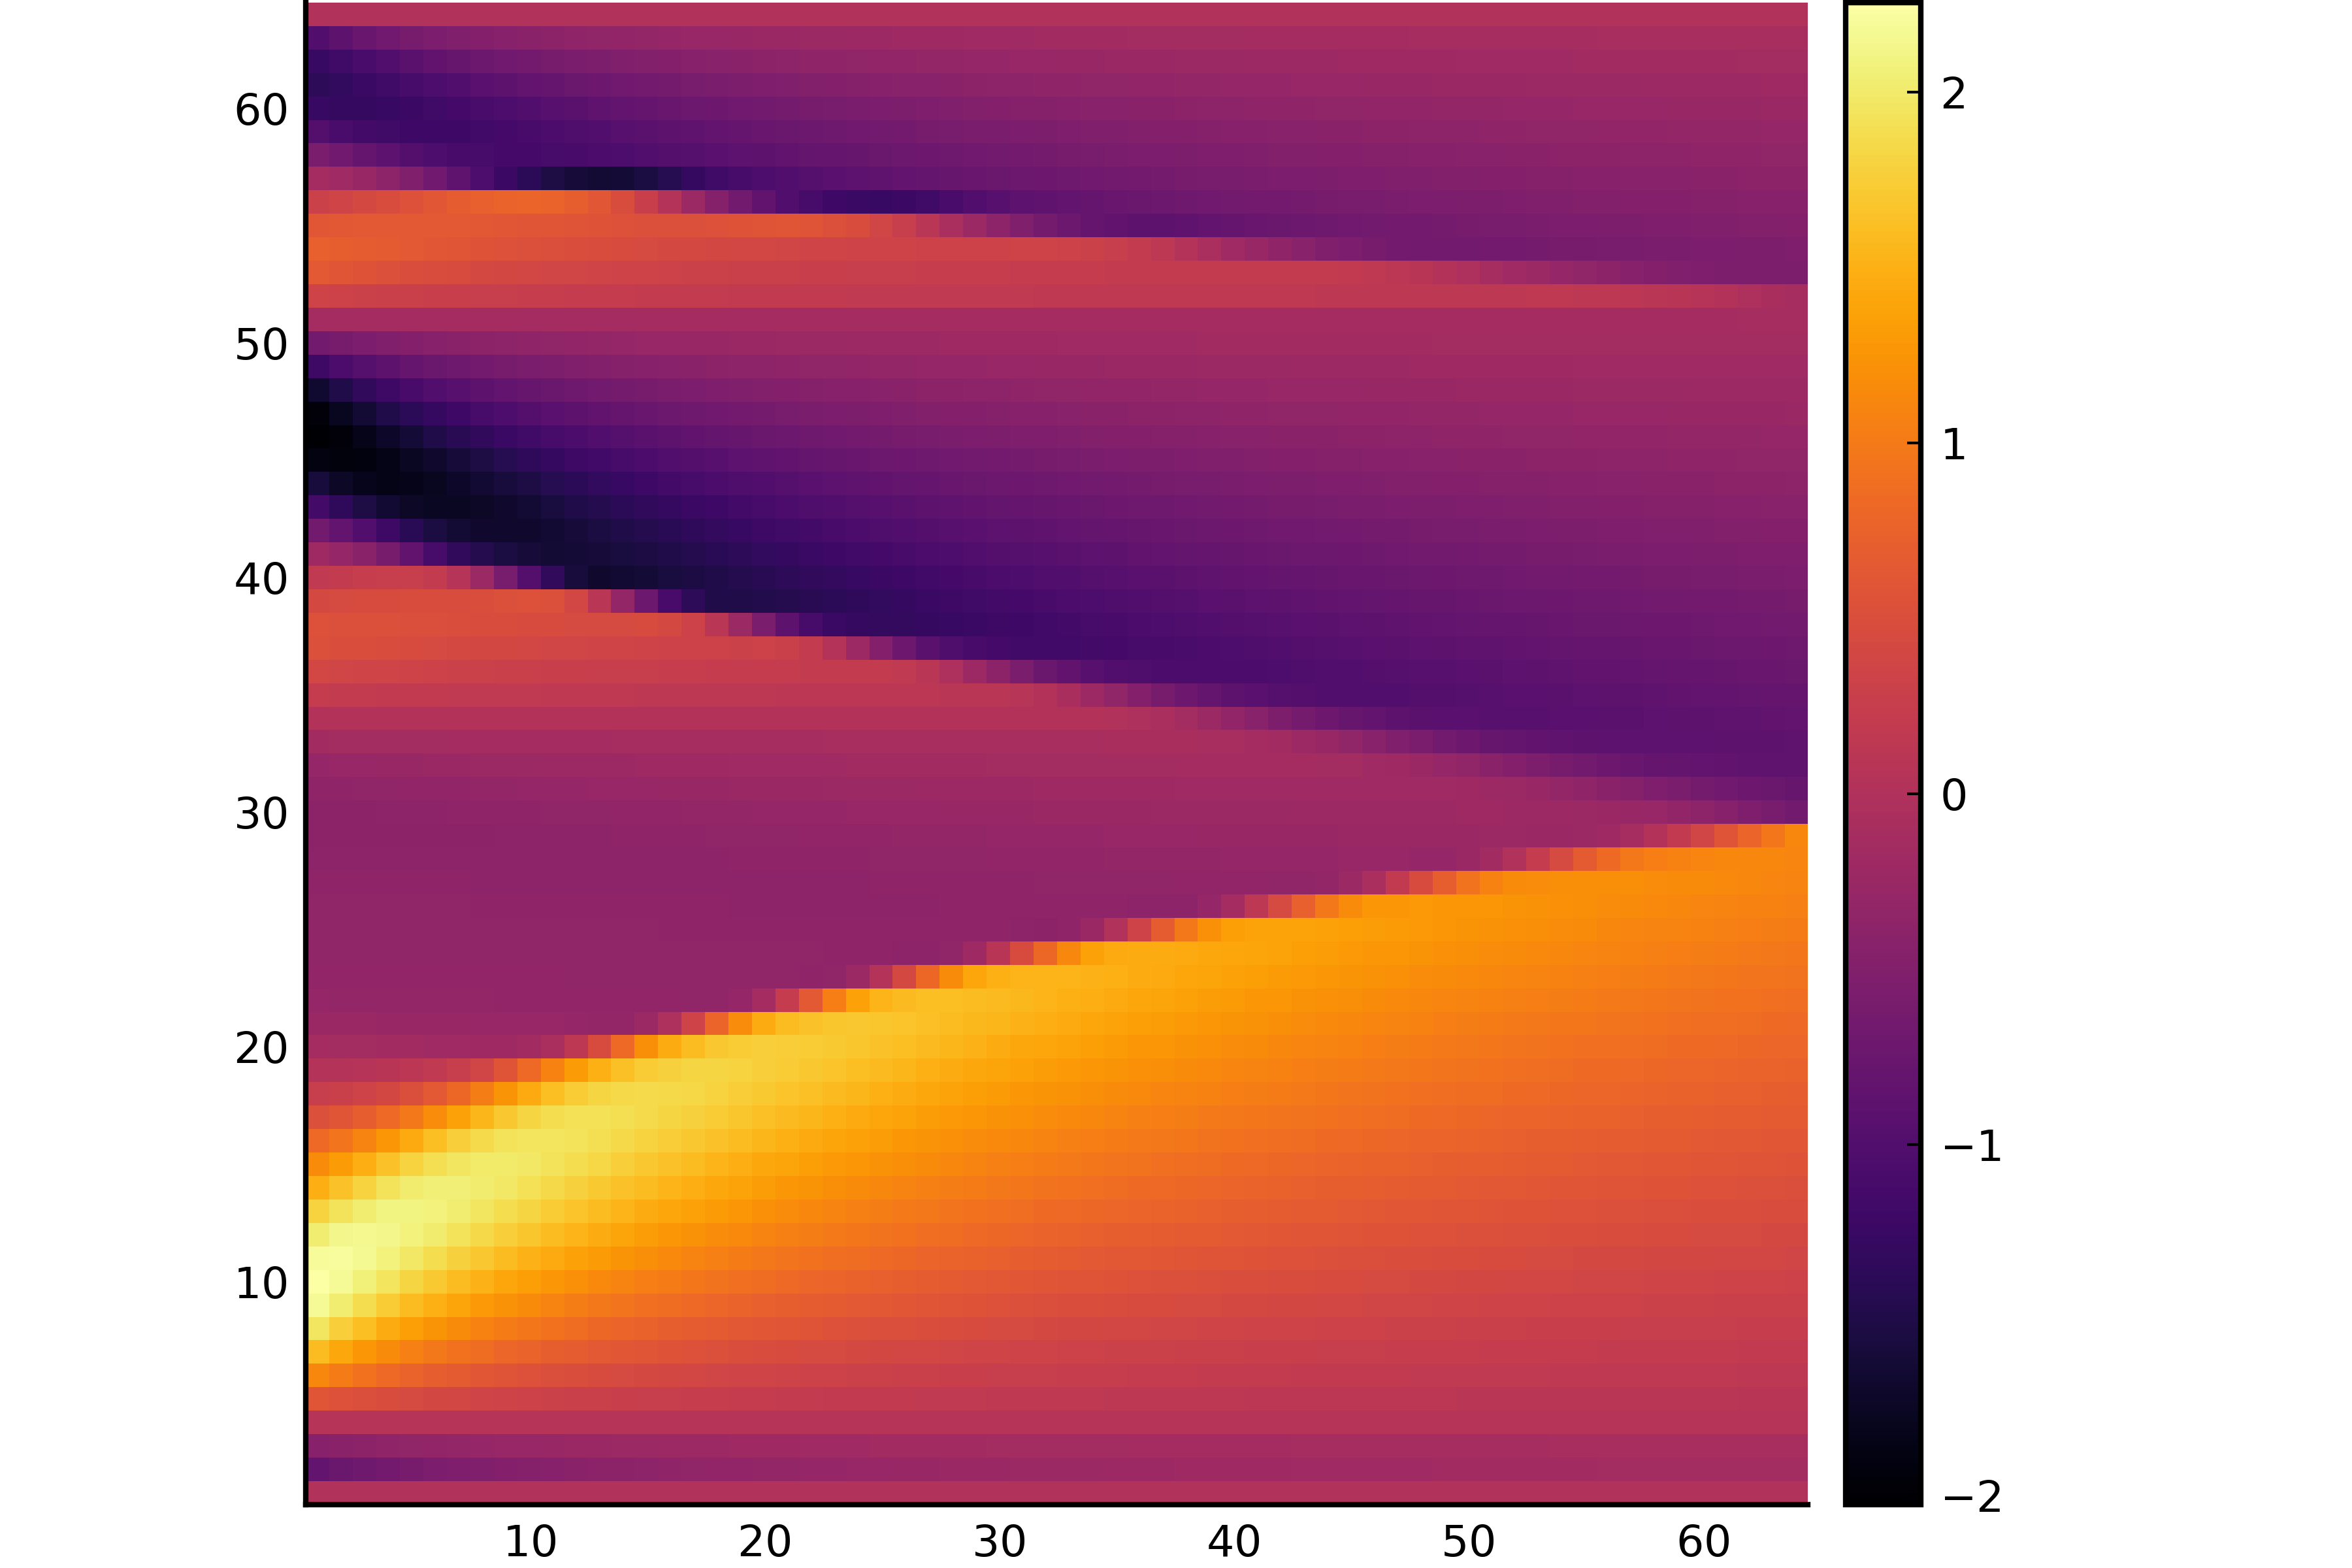

In [267]:
t1, u1 = Equations.get_burgers_godunov(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u1, "") # need to reverse u, odesolver switch dimensions

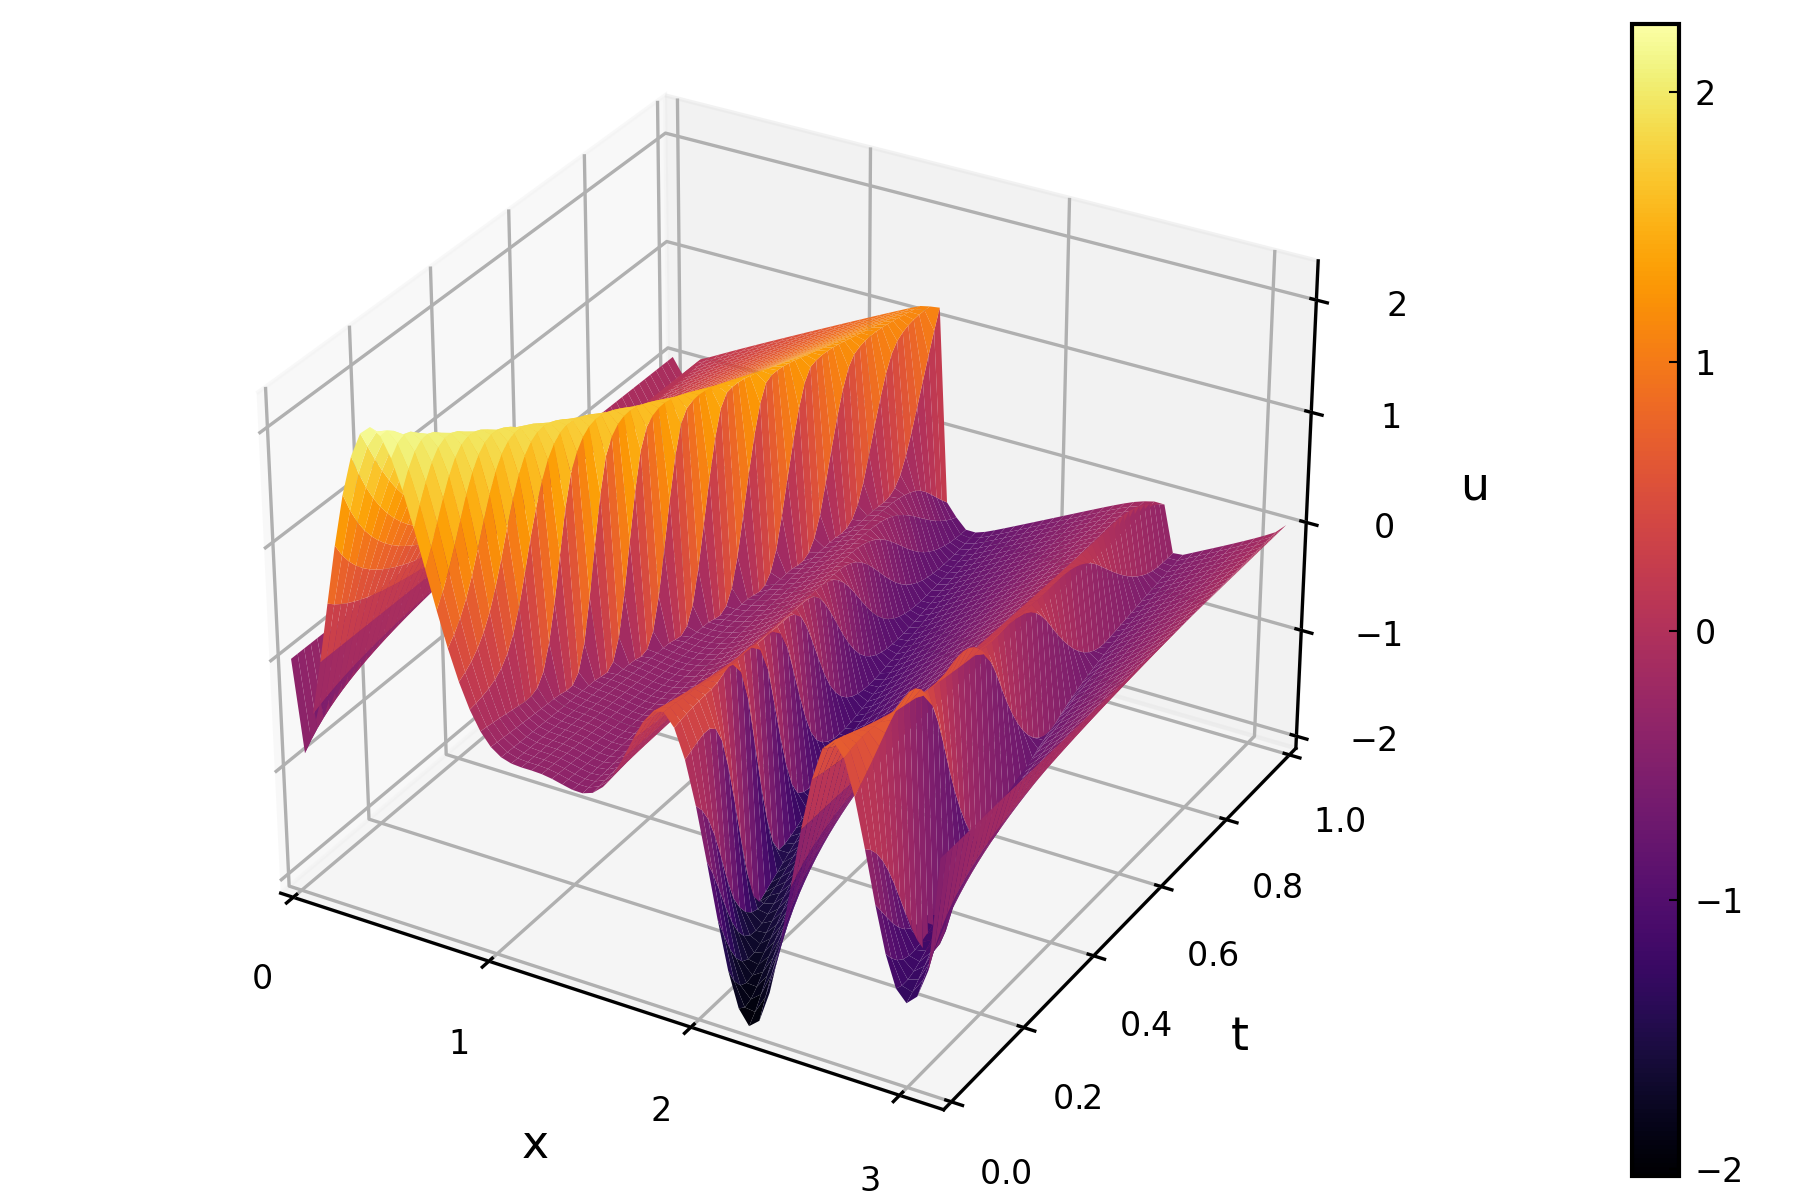

In [282]:
plot(x, t1, u1', st = :surface, xlabel = "x", ylabel = "t", zlabel = "u")
plot!(dpi=300)

### CCDF

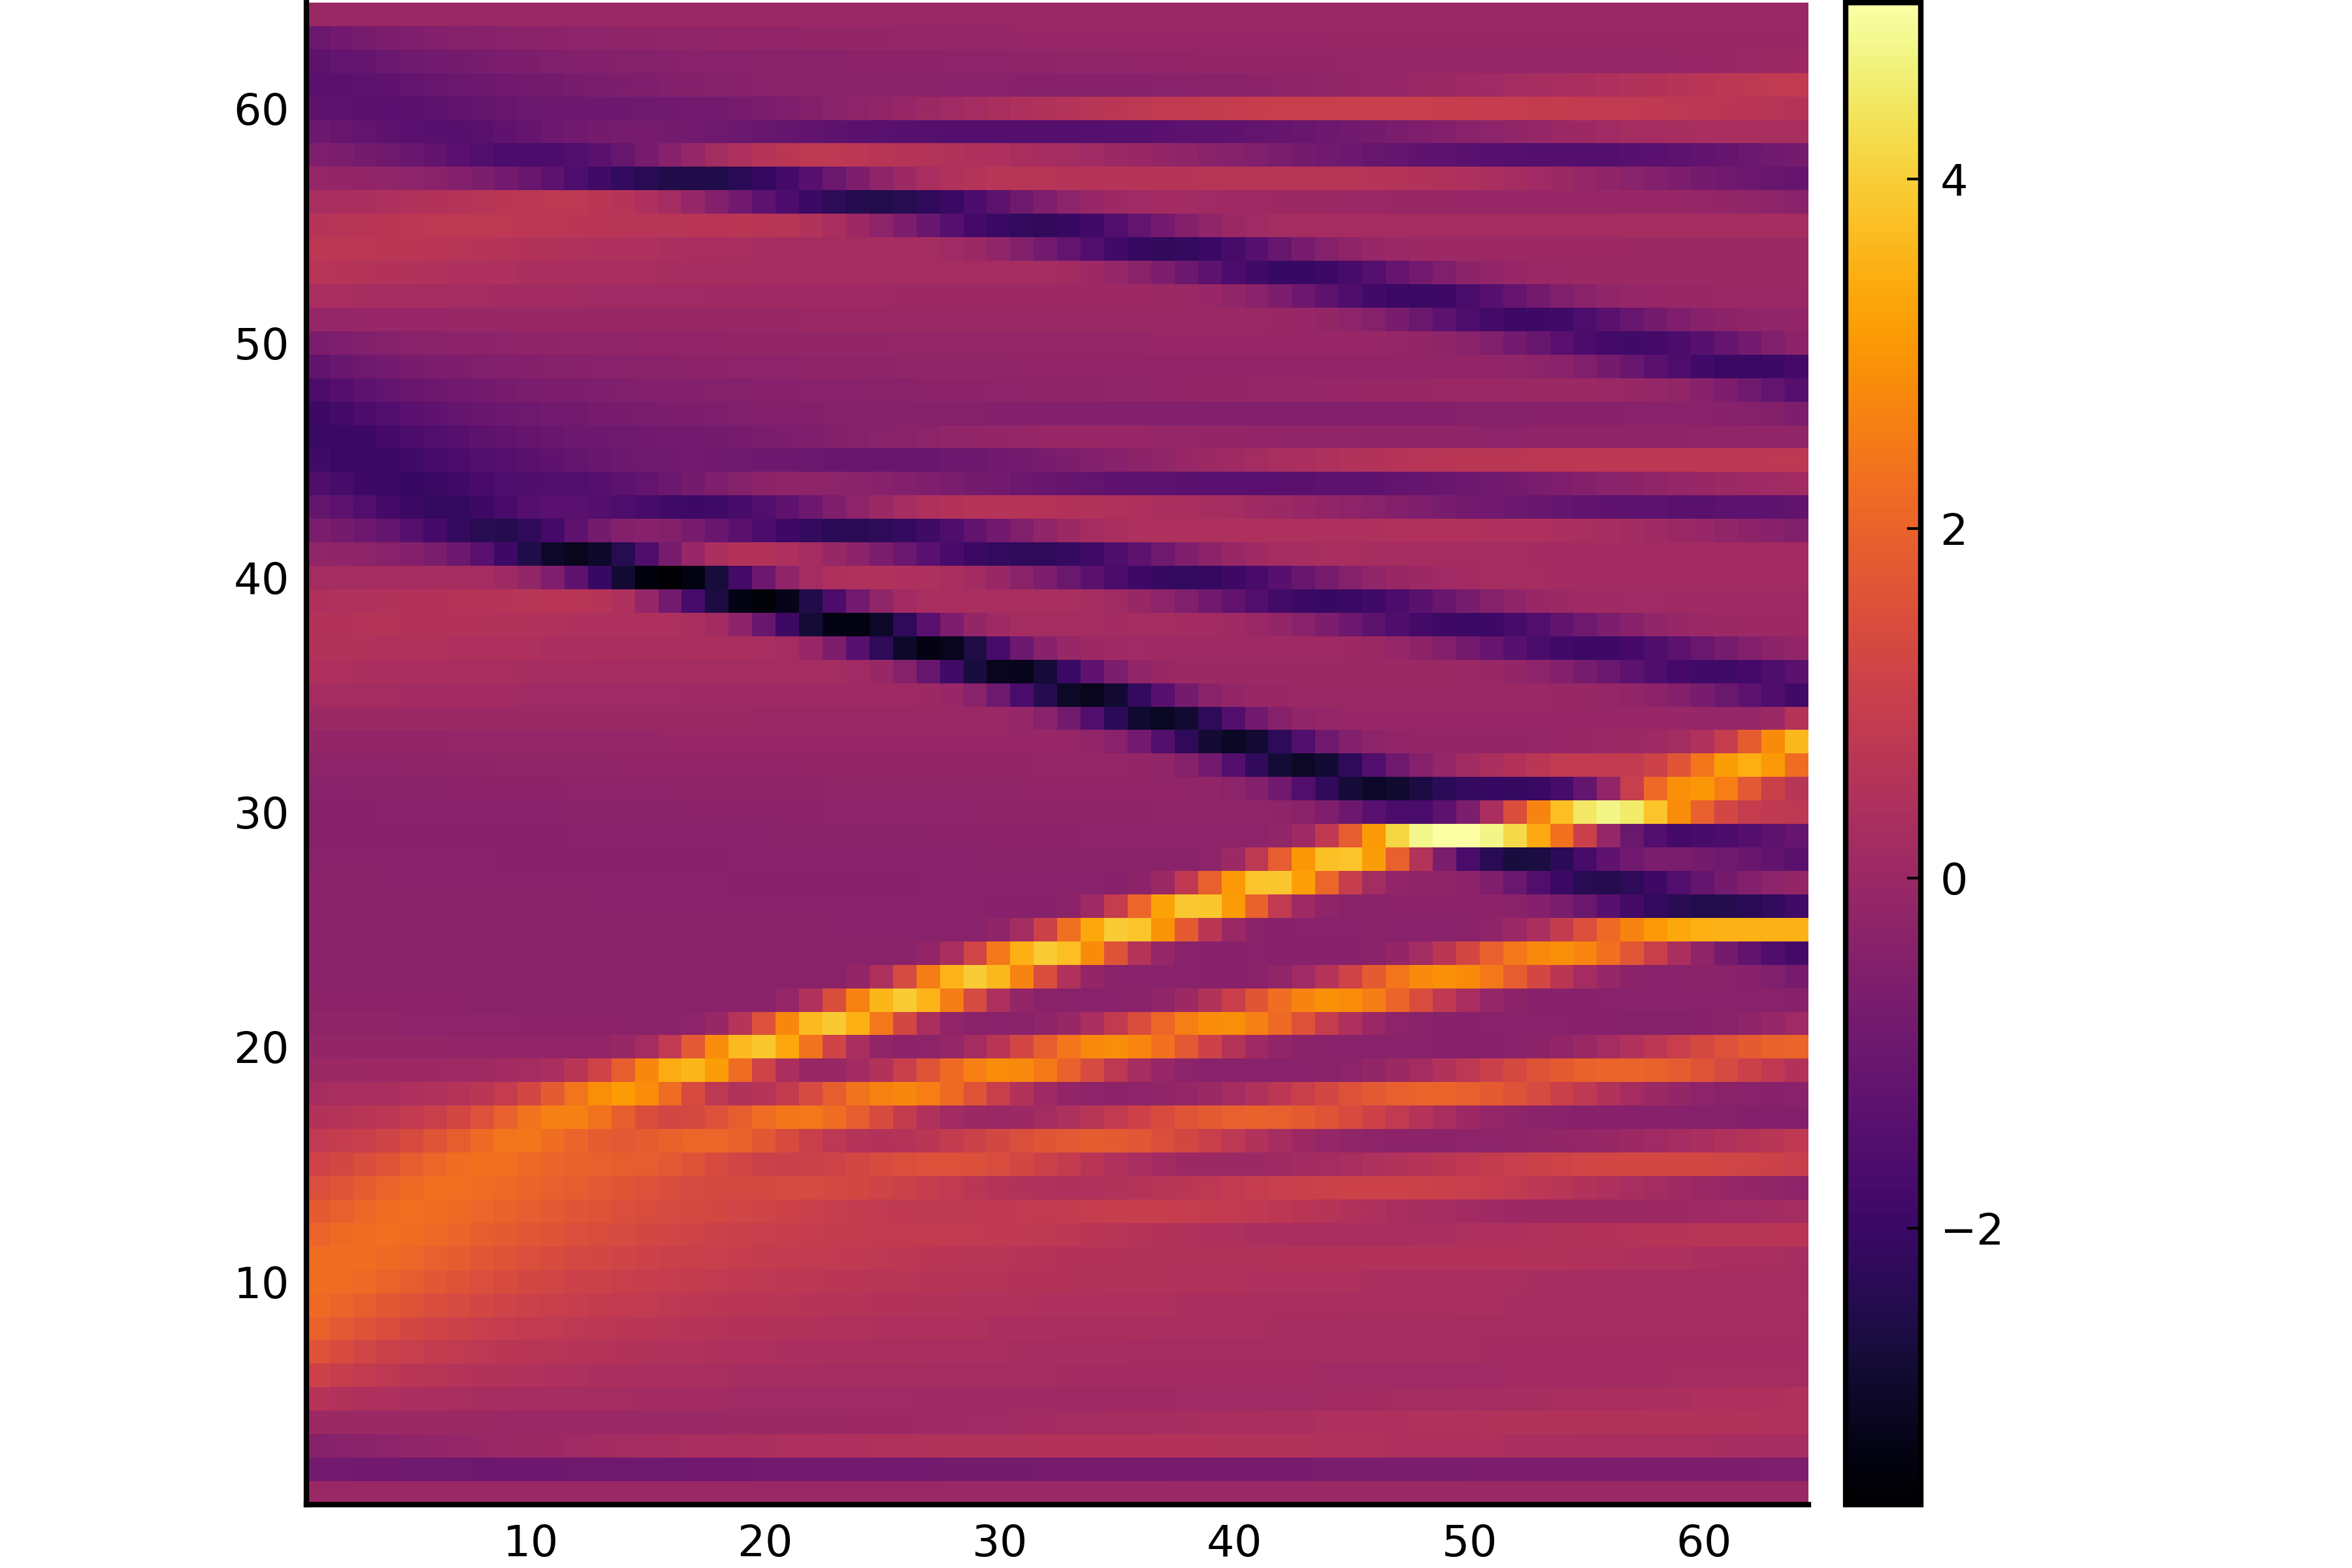

In [268]:
t2, u2 = Equations.get_burgers_ccdf(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u2, "")

### Pseudo-spectral method

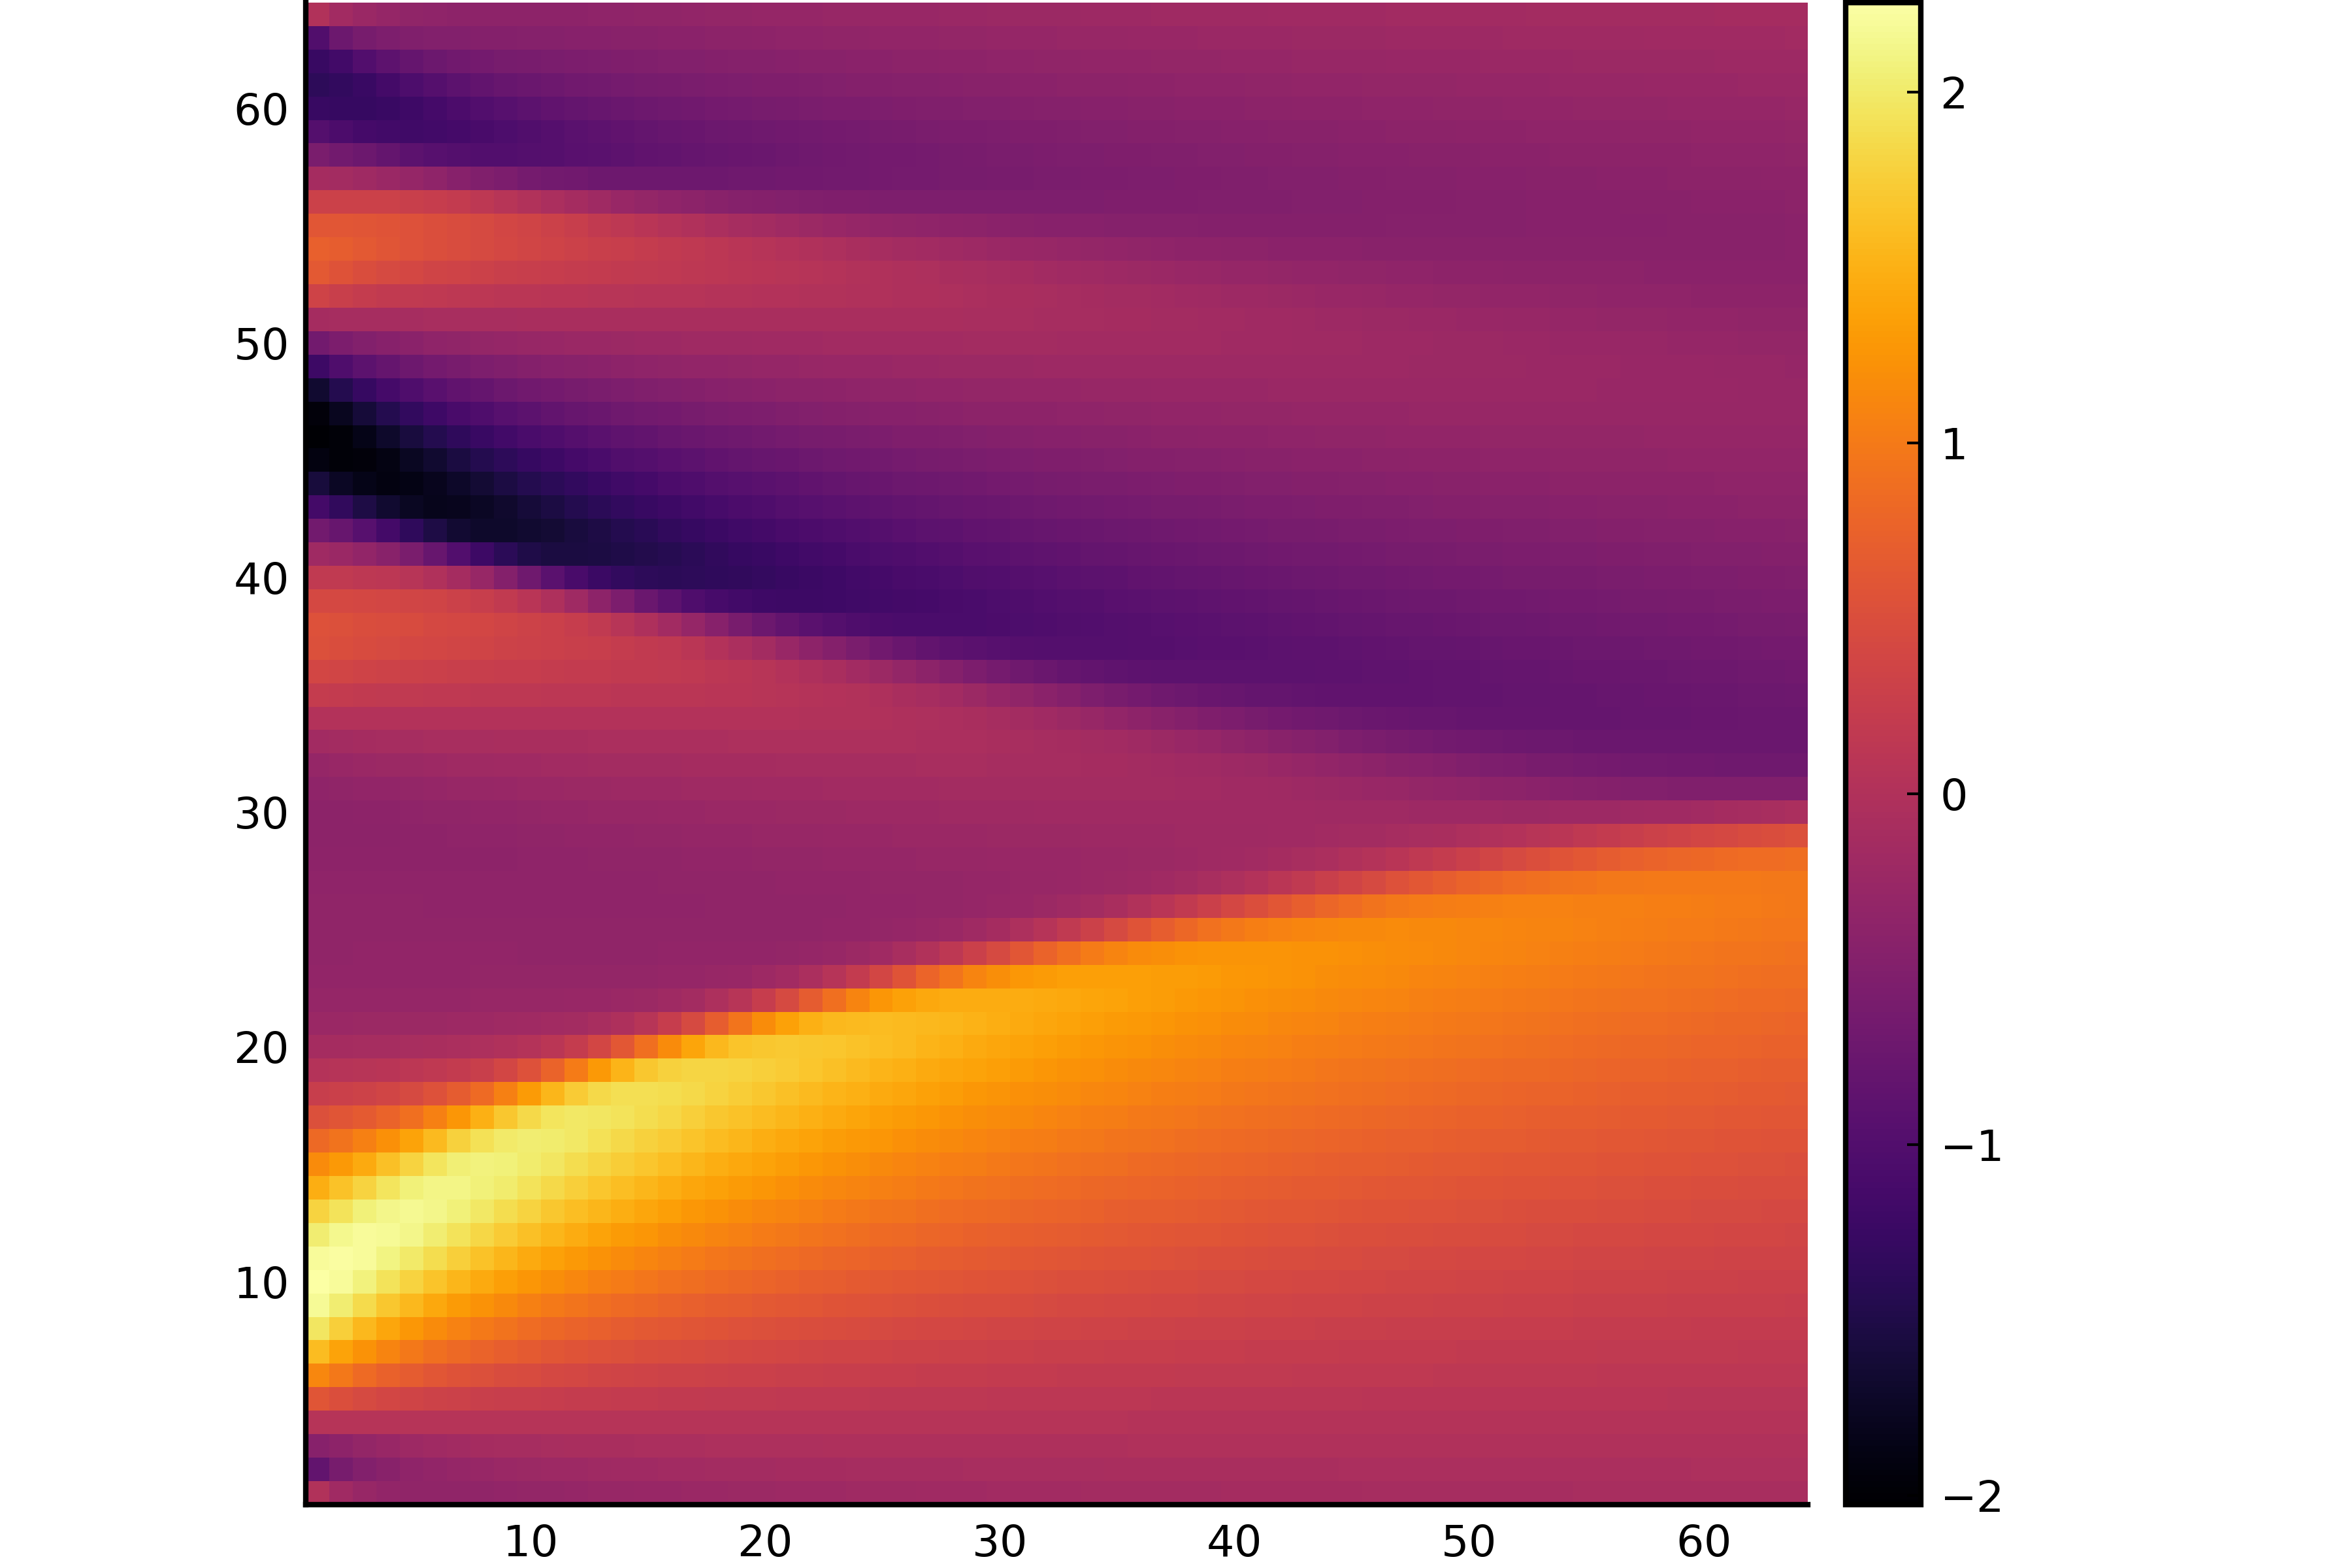

In [276]:
t3, u3 = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u3, "")

### Thesis screenshots

In [295]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
high_t, high_dim = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n * 32, x_n * 32, nu, 2);

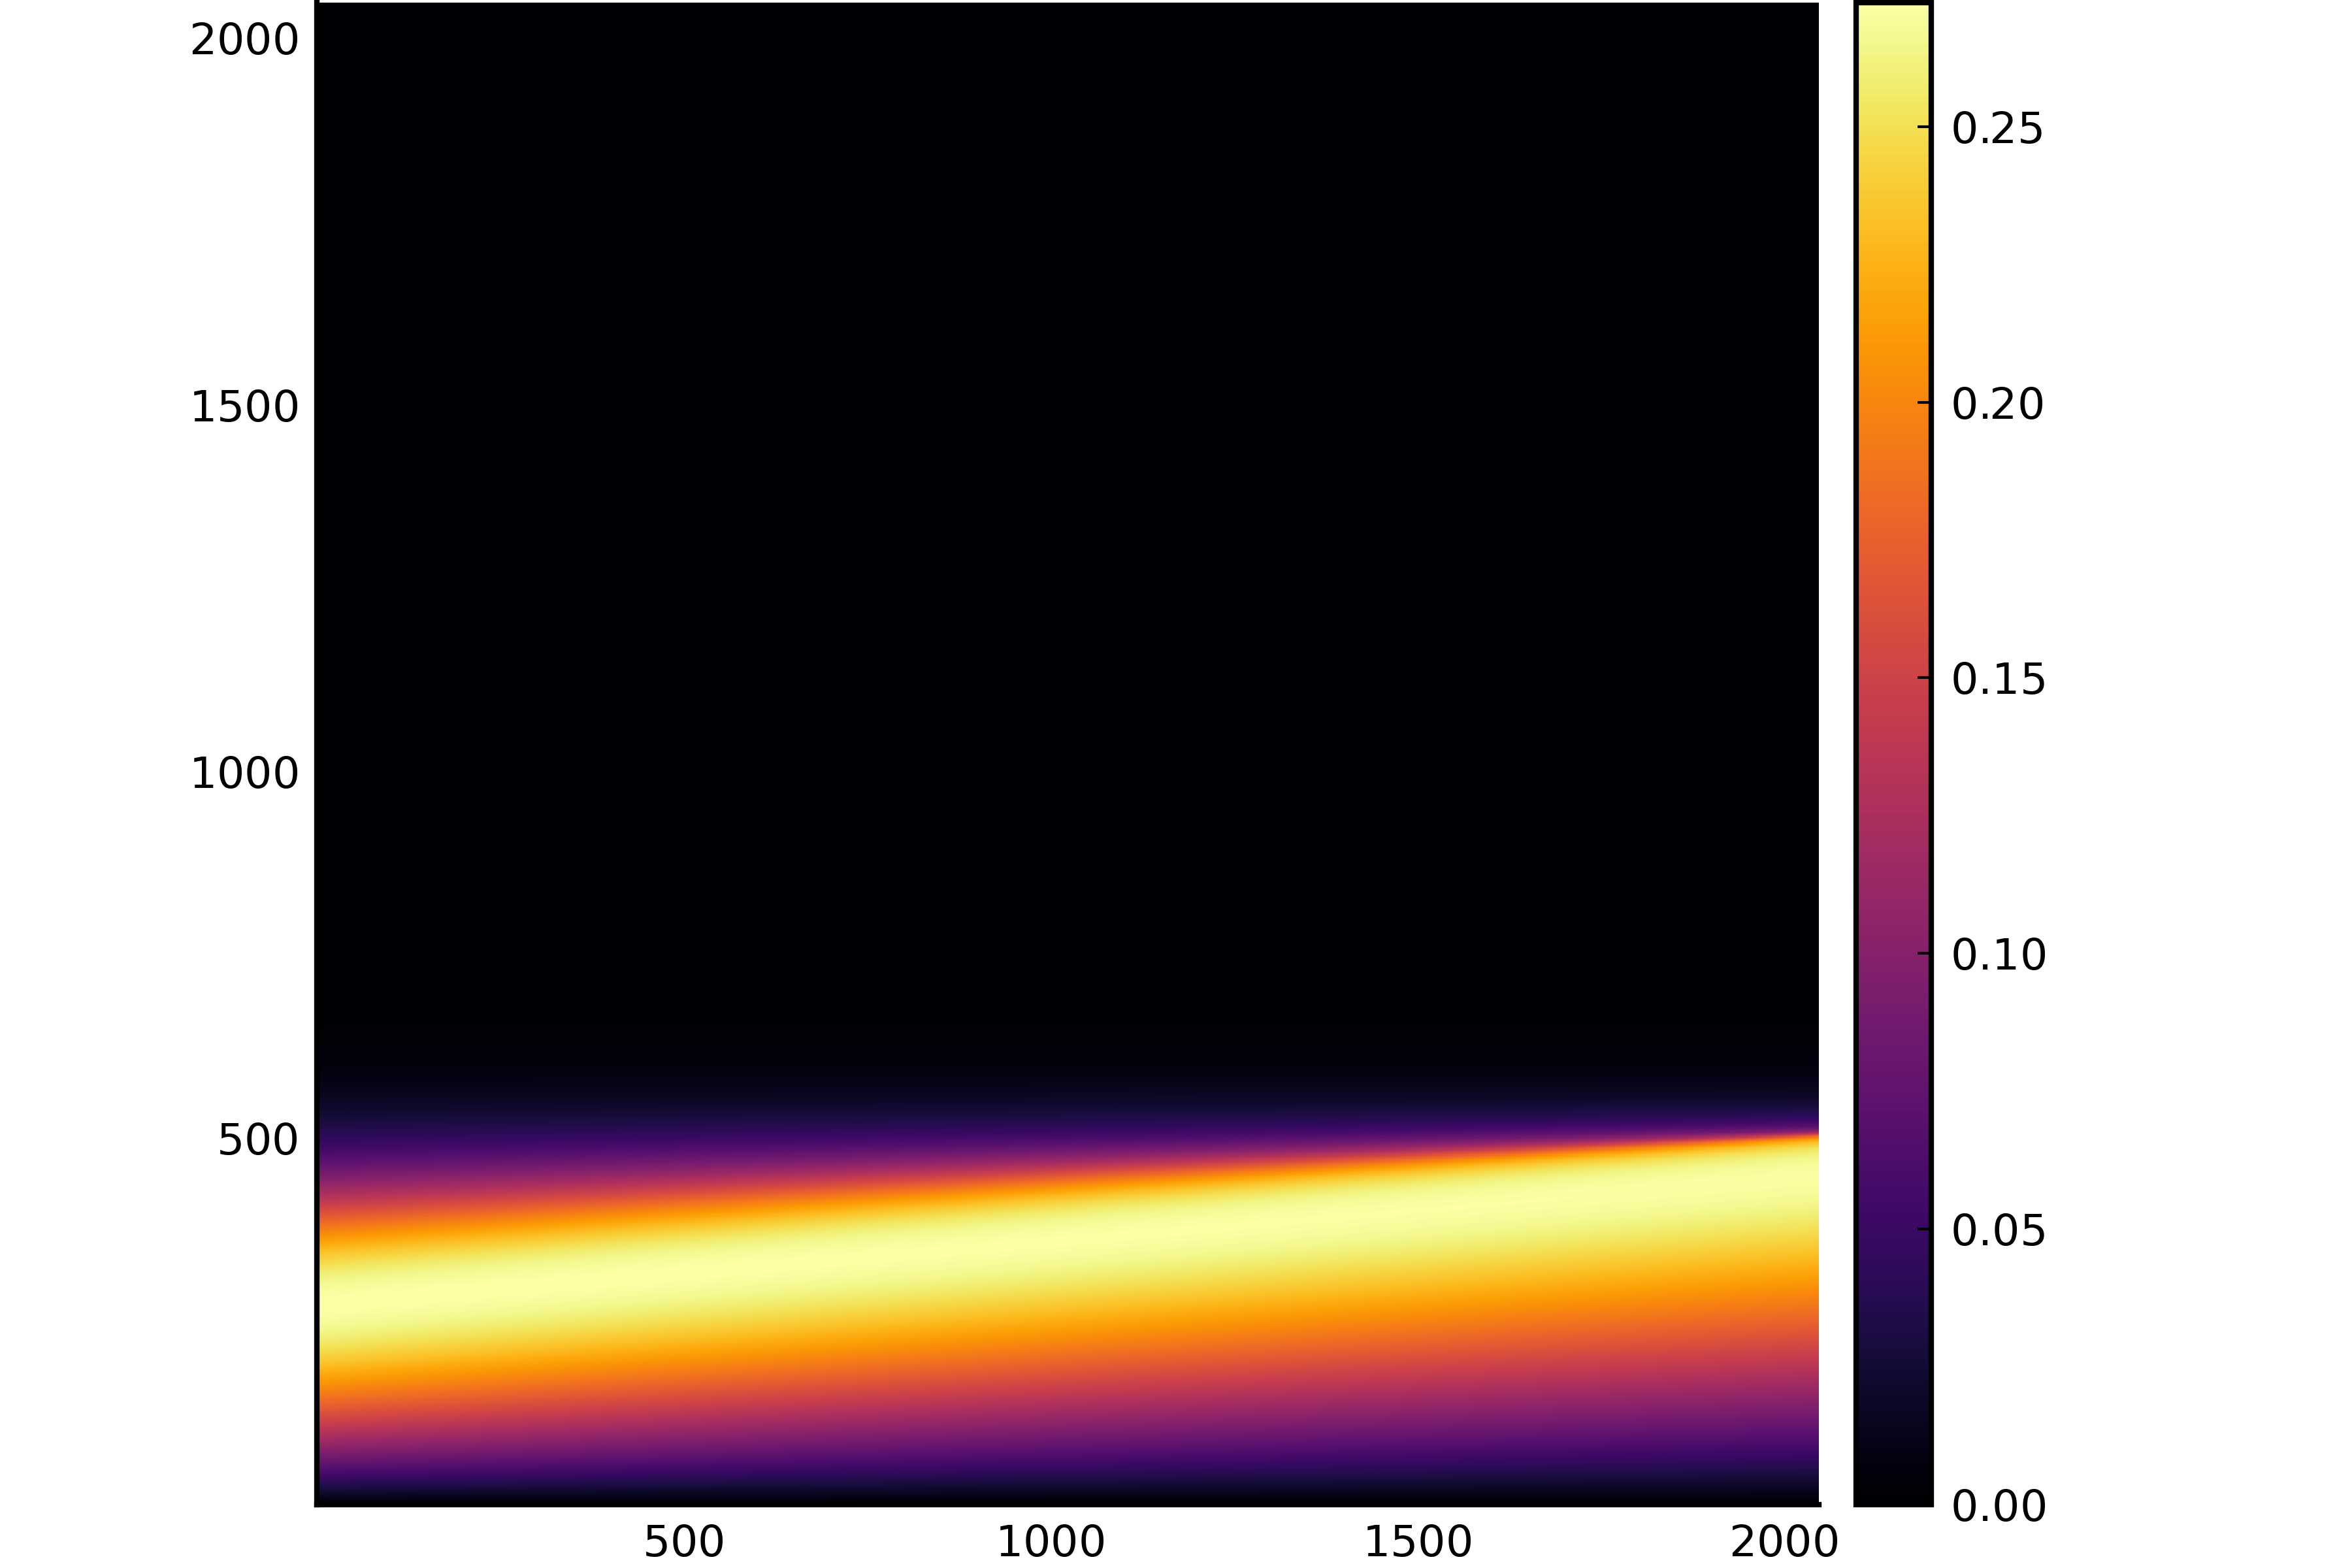

In [294]:
low_dim = ProcessingTools.downsampling(high_dim, 32);
low_t = LinRange(t_min, t_max, t_n);
GraphicTools.show_state(high_dim, "")

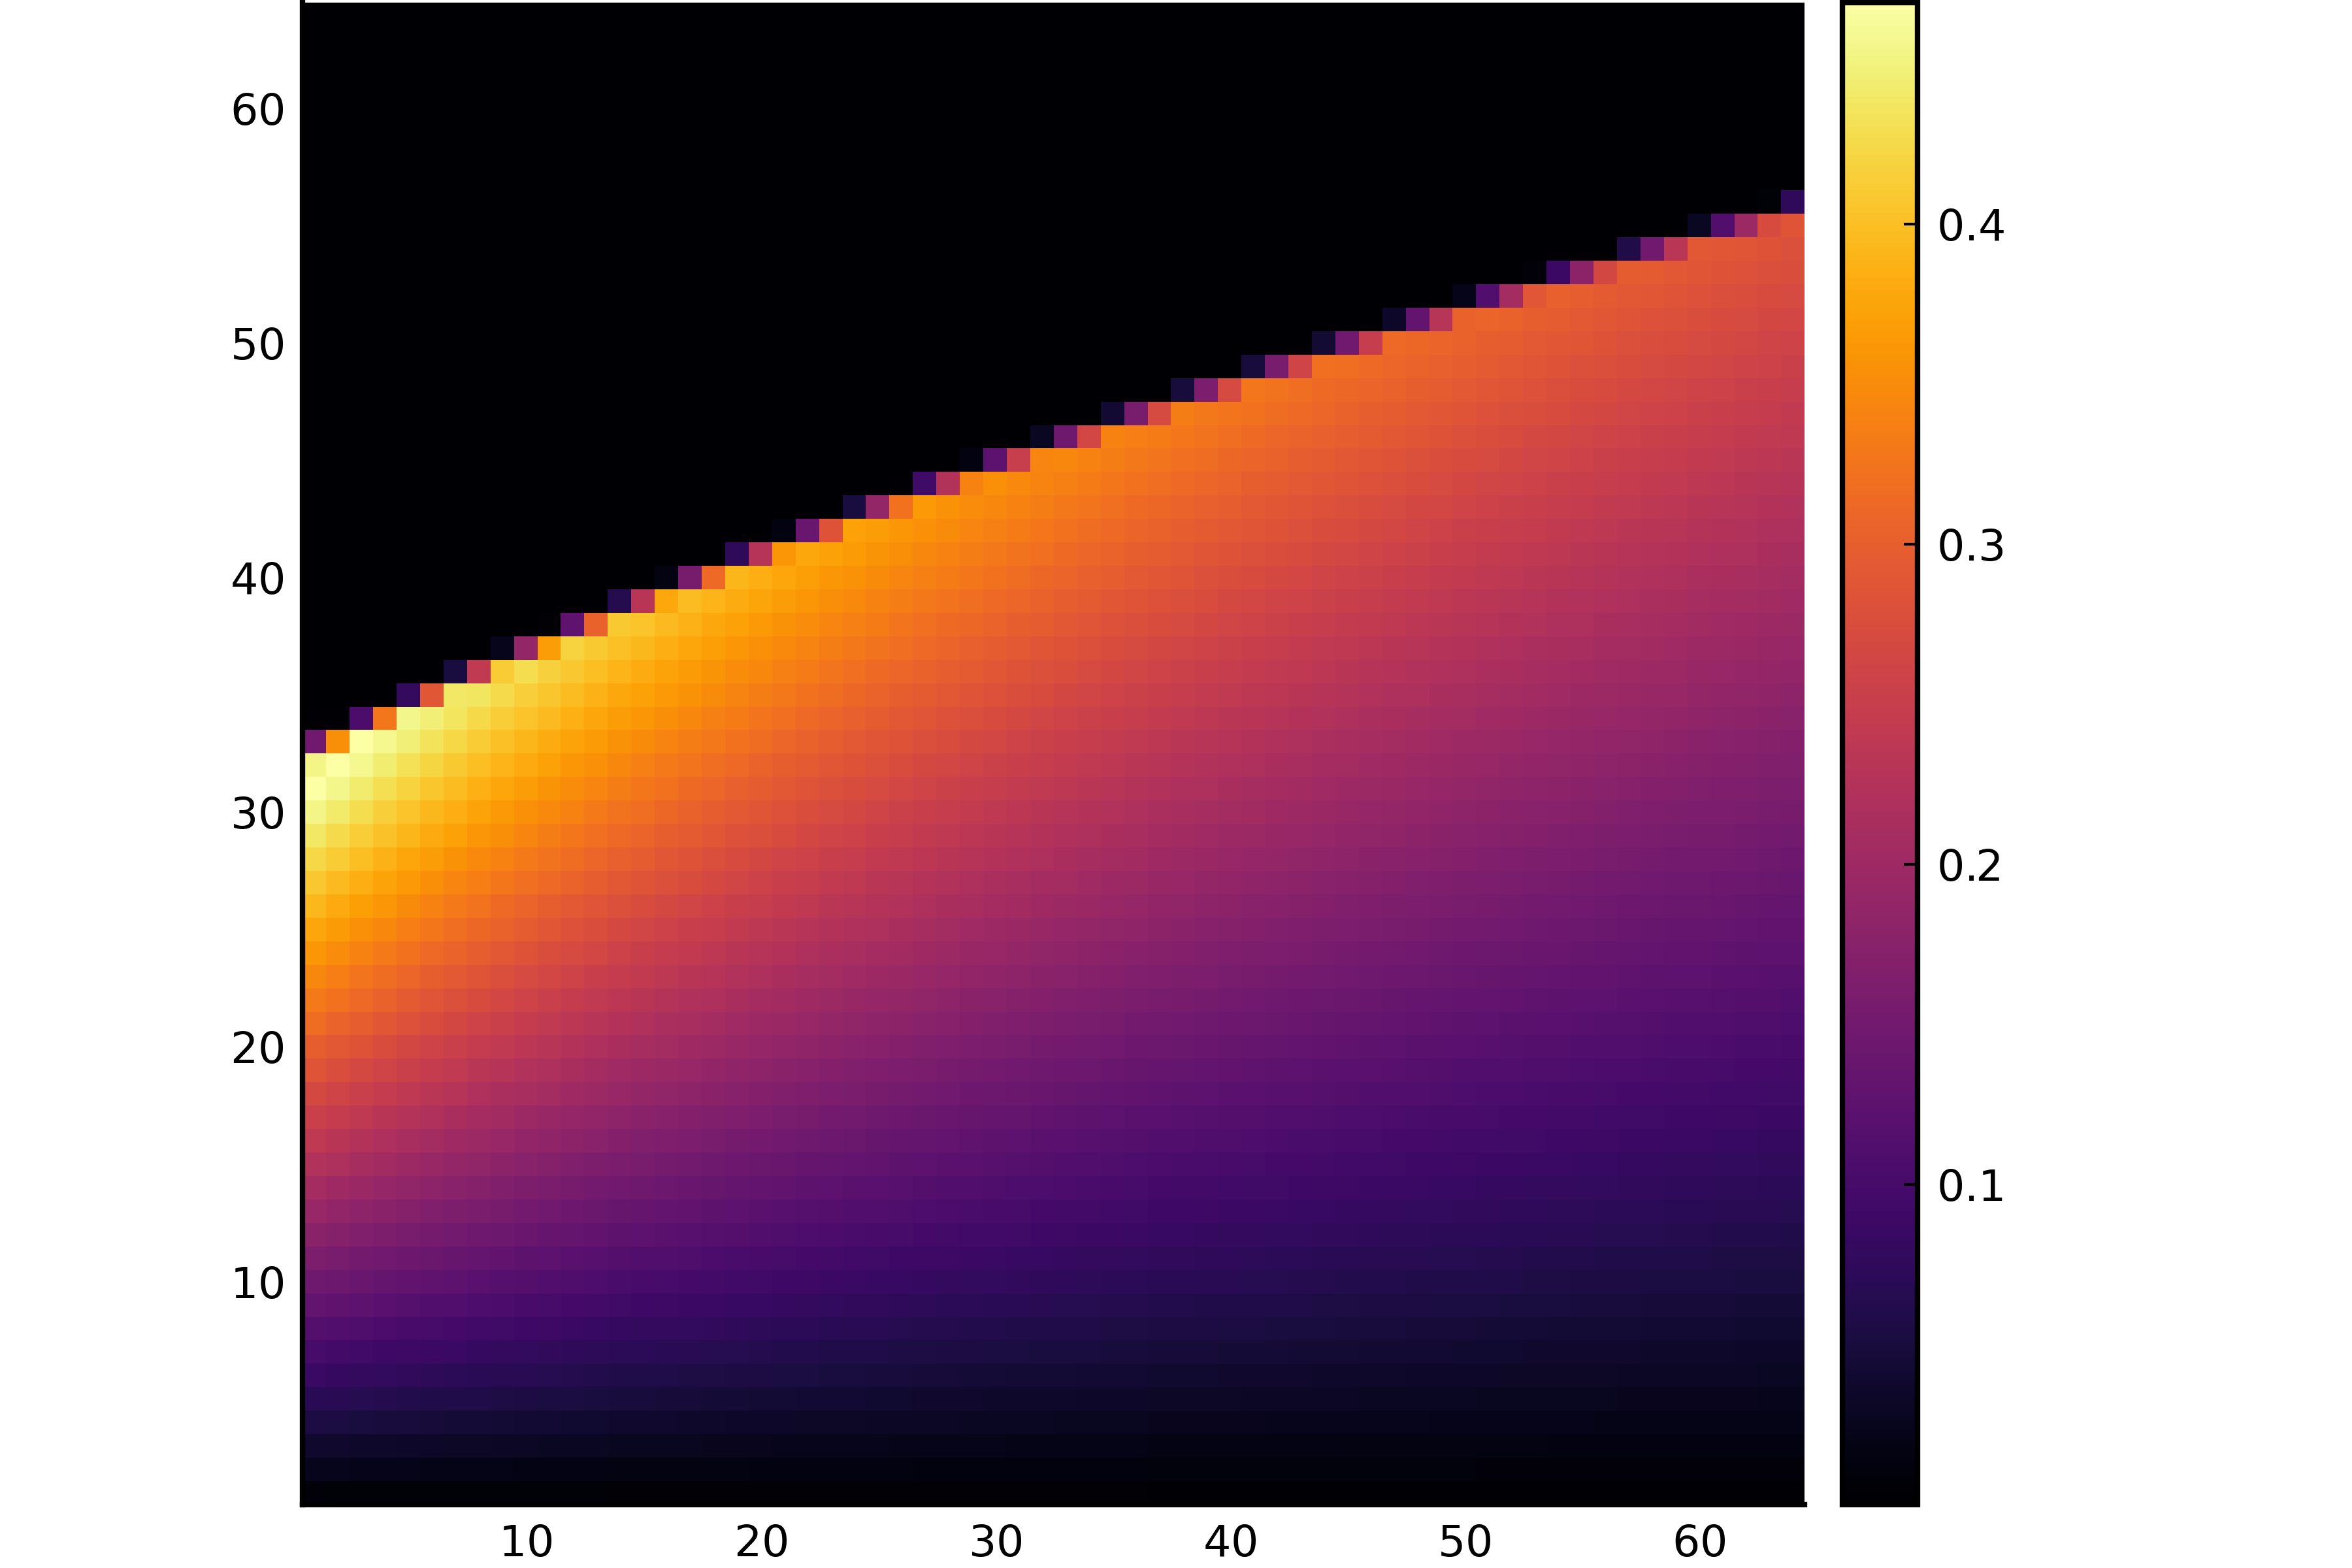

In [151]:
GraphicTools.show_state(low_dim, "")

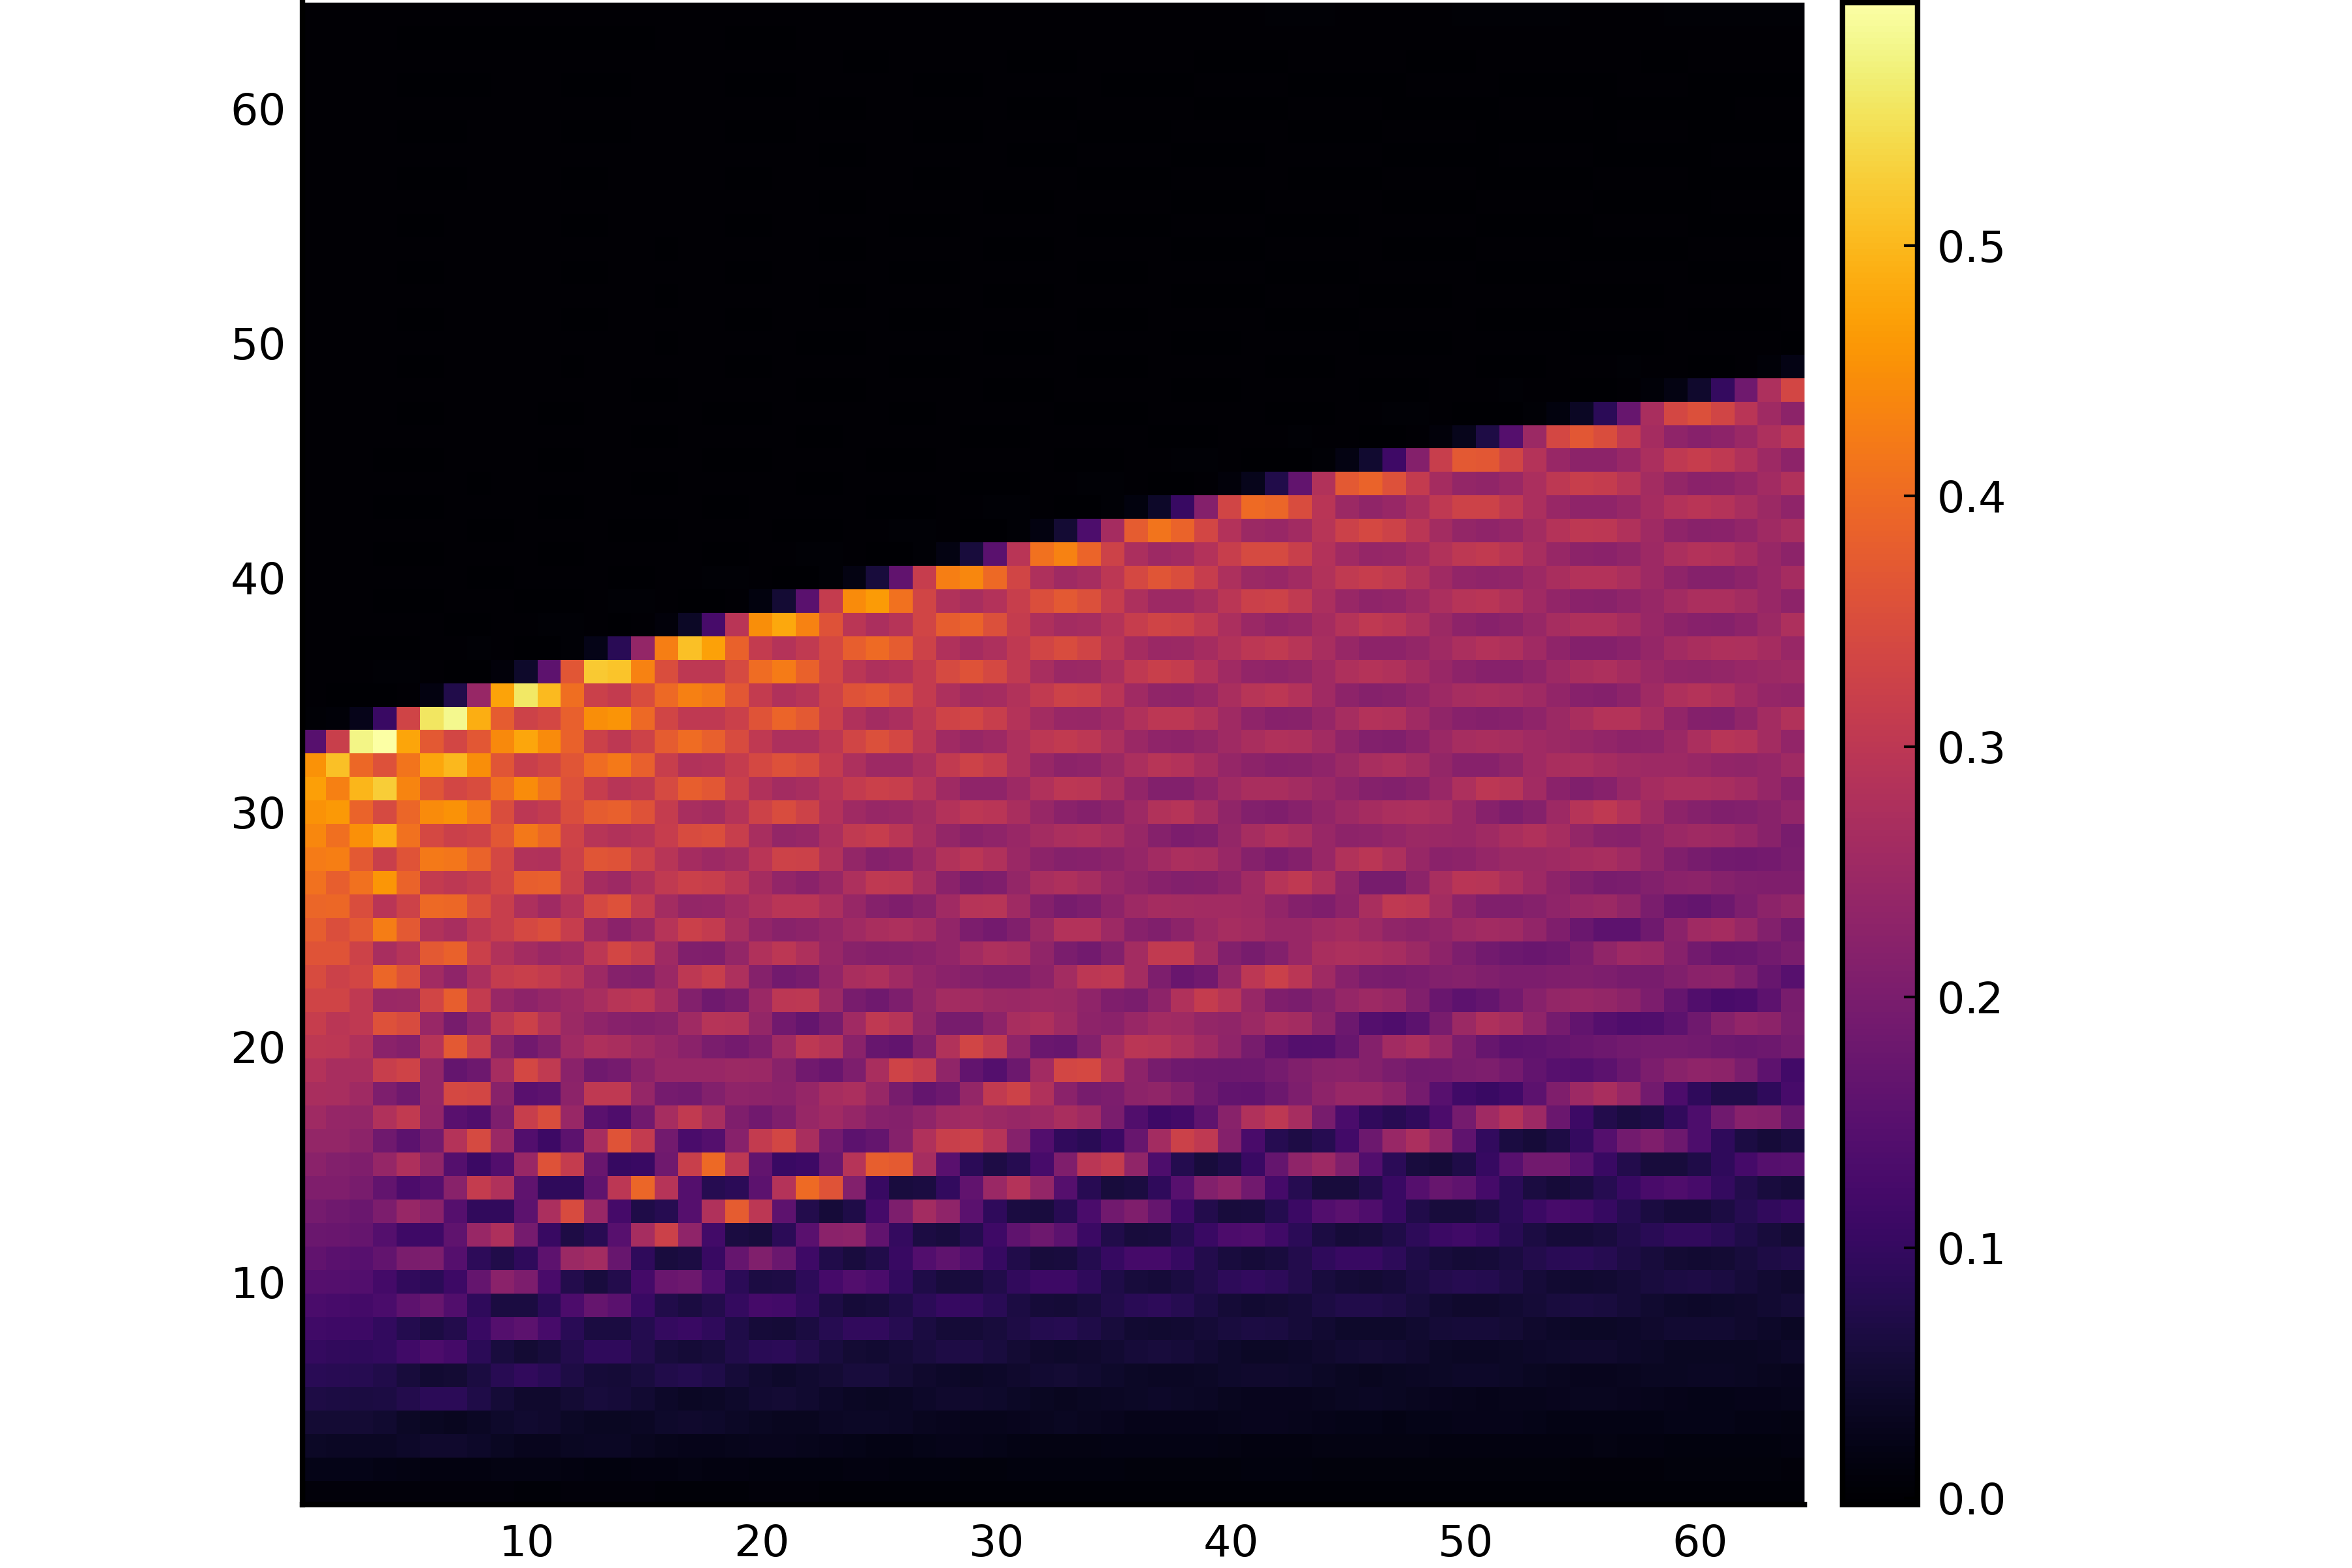

In [154]:
t4, u4 = Equations.get_burgers_fft(t, dx, x_n, 0.0001, low_dim[:, 1]);
GraphicTools.show_state(u4, "")

### POD-GC

In [ ]:
t, u2 = Equations.get_burgers_fft(t, dx, x_n, 0.03, u0[1, :]);
GraphicTools.show_state(u2, "Snapshot") # need to reverse u, odesolver switch dimensions

In [ ]:
plot(x, t, u2, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

In [ ]:
# ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
# GraphicTools.show_state(u_a, "Snapshot generator")

In [290]:
bas, ū = POD.generate_pod_basis(u3, true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;
# display(
#     plot(
#         GraphicTools.show_state(u, ""),
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(tmp, ""),
#         GraphicTools.show_err(u2, tmp, "");
#         layout = (2, 2)
#     )
# );

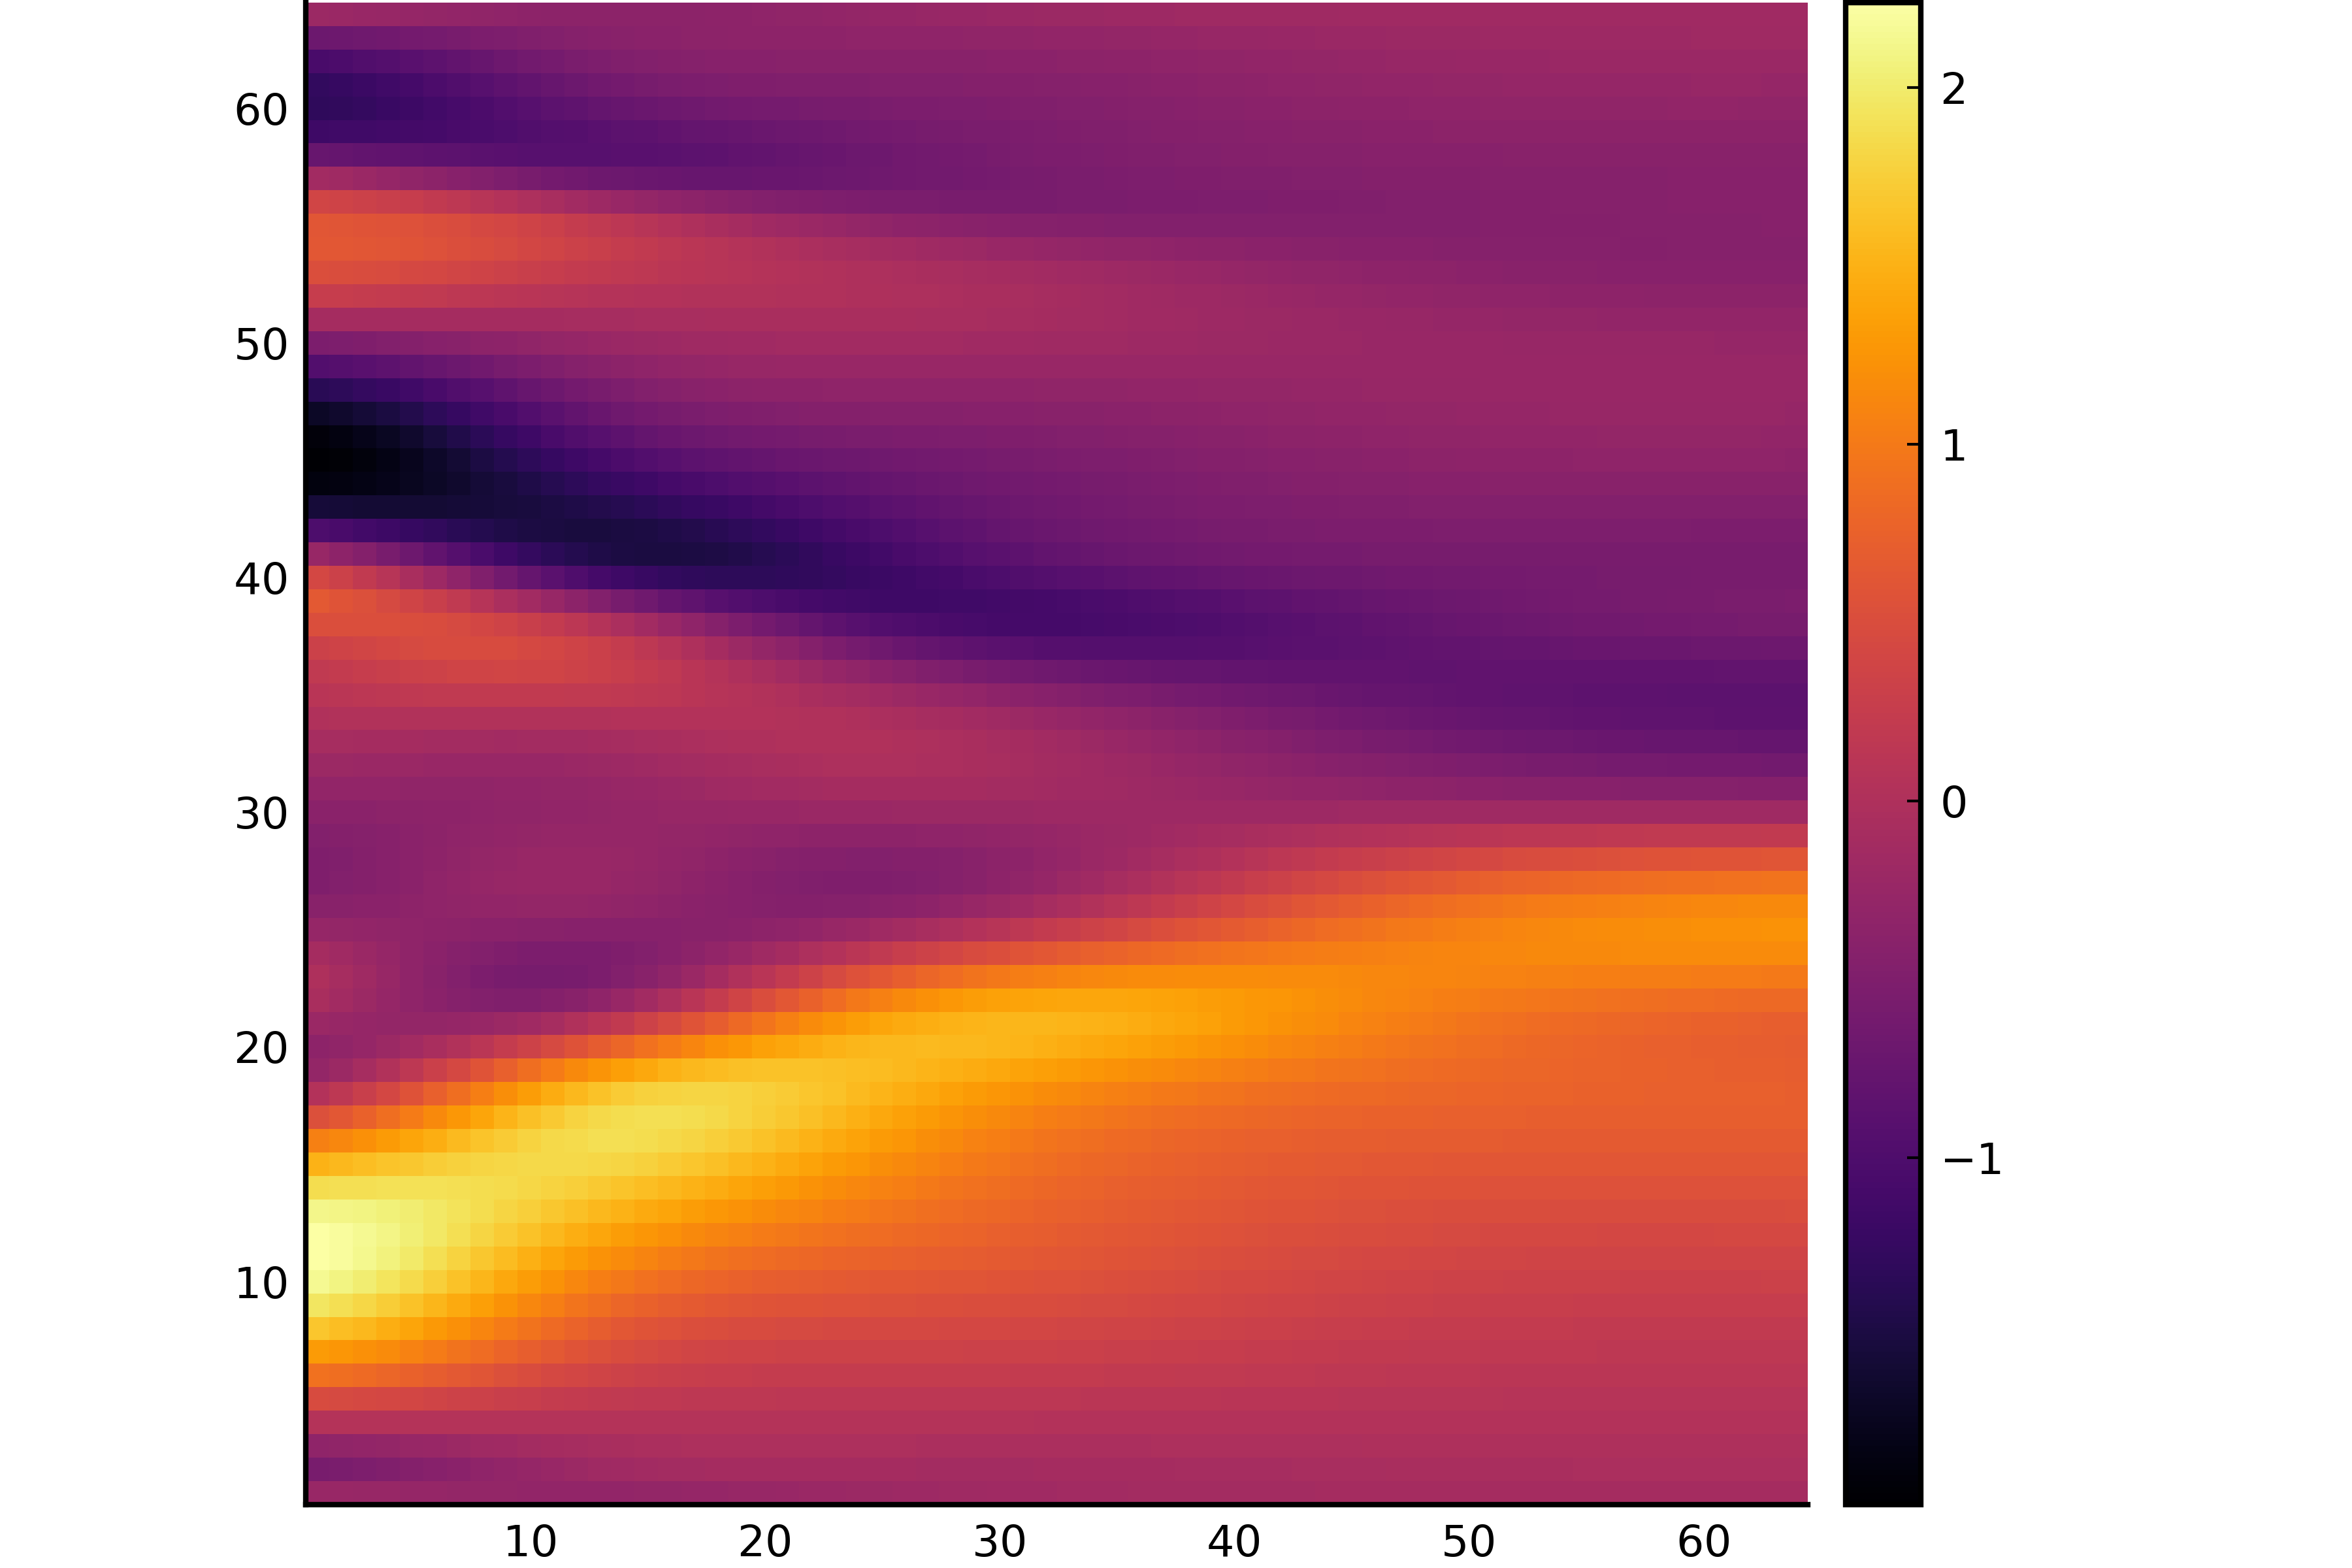

In [291]:
GraphicTools.show_state(tmp, "")
# GraphicTools.show_err(u2, tmp, "")

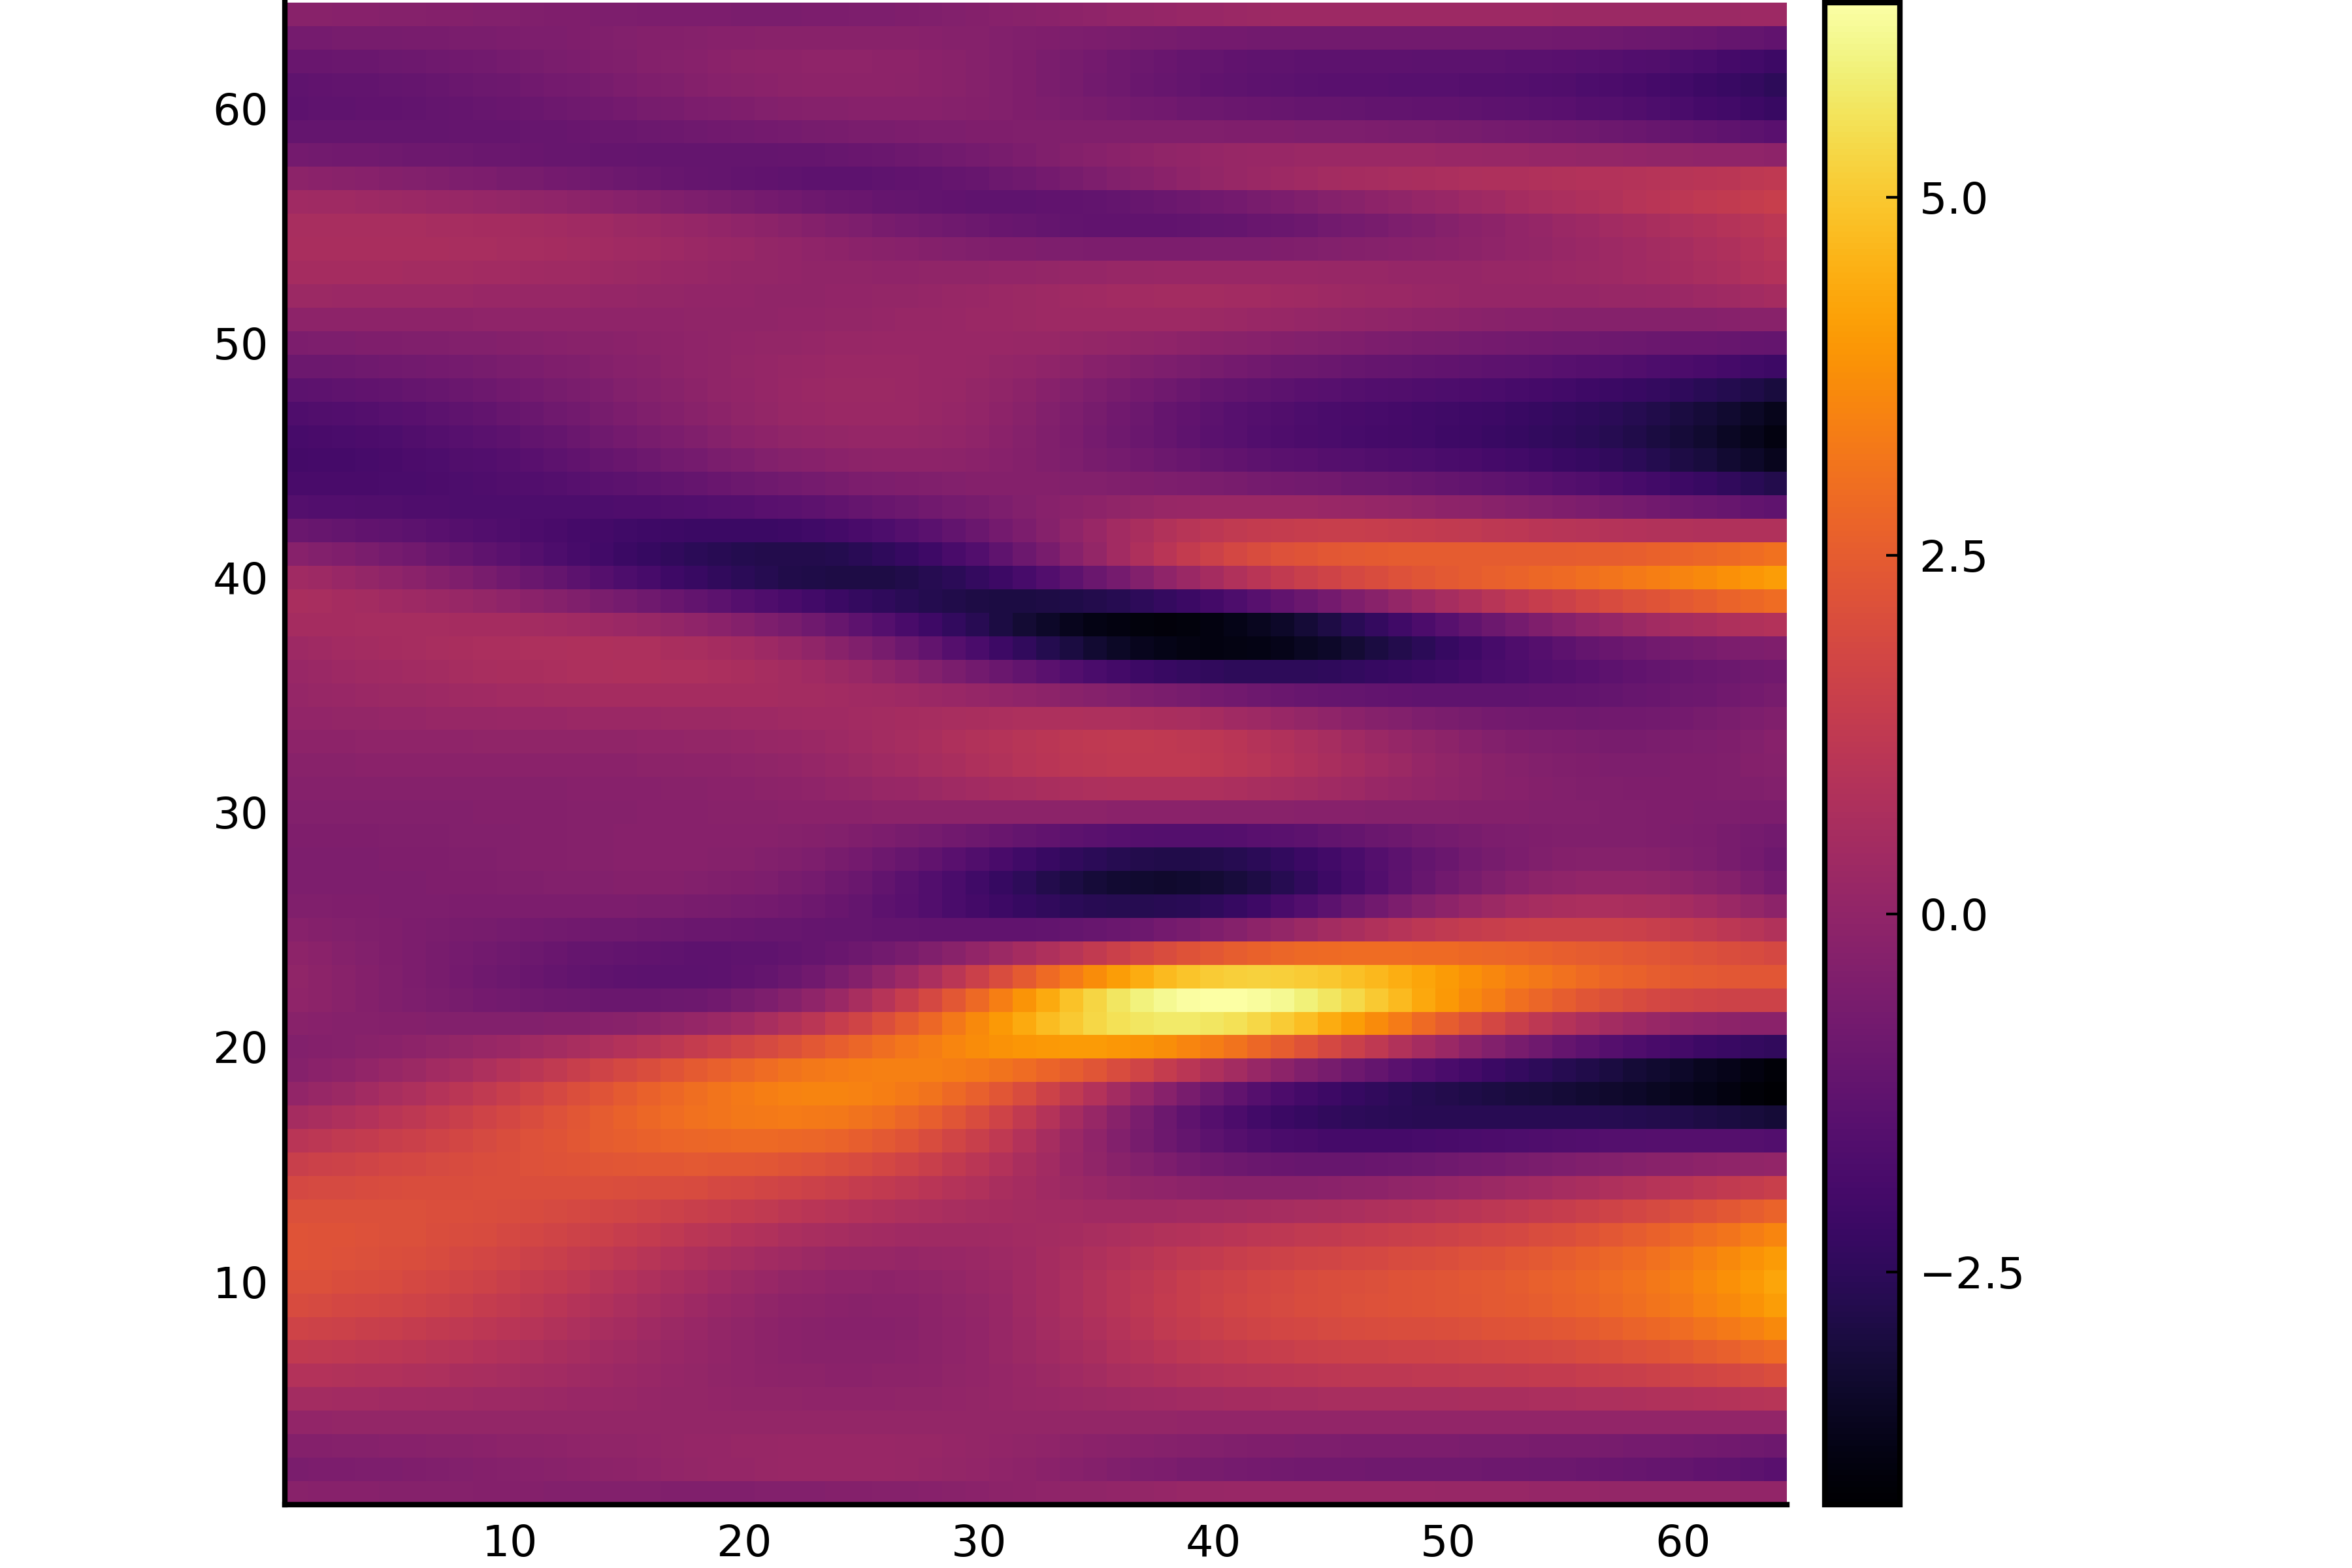

In [292]:
Ū = Equations.galerkin_projection(t, u3, ϕ[:, 1:3], 0., dx, dt);
# display(
#     plot(
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(Ū, ""),
#         GraphicTools.show_err(u2, Ū, ""),
#         GraphicTools.show_err(u2, Ū, "");
#         layout = (2, 2)
#     )
# );
GraphicTools.show_state(Ū, "")
# GraphicTools.show_err(u2, Ū, "")

## Analytical solution initial conditions

In [ ]:
#u0 = InitialFunctions.advecting_shock(t, x, nu);
u0 = exp.(-16 .* (x.^2));
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0);
GraphicTools.show_state(u, "Snapshot")

In [ ]:
plot(t, x, u, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

---
# Generate data

In [7]:
dataset_1k = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1024, 2, 1, false, "./src/dataset/burgers_high_dim_training_set_2.jld2", "training_set");
# high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];
# nu_dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_nu_variational_dataset.jld2")["training_set"];
# dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_nu_variational_dataset.jld2")["training_set"];

Item1Item2Item3Item4Item5Item6Item7Item8Item9Item10Item11Item12Item13Item14Item15Item16Item17Item18Item19Item20Item21Item22Item23Item24Item25Item26Item27Item28Item29Item30Item31Item32Item33Item34Item35Item36Item37Item38Item39Item40Item41Item42Item43Item44Item45Item46Item47Item48Item49Item50Item51Item52Item53Item54Item55Item56Item57Item58Item59Item60Item61Item62Item63Item64Item65Item66Item67Item68Item69Item70Item71Item72Item73Item74Item75Item76Item77Item78Item79Item80Item81Item82Item83Item84Item85Item86Item87Item88Item89Item90Item91Item92Item93Item94Item95Item96Item97Item98Item99Item100Item101Item102Item103Item104Item105Item106Item107Item108Item109Item110Item111Item112Item113Item114Item115Item116Item117Item118Item119Item120Item121Item122Item123Item124Item125Item126Item127Item128Item129Item130Item131Item132Item133Item134Item135Item136Item137Item138Item139Item140Item141Item142Item143Item144Item145Item146Item147Item148Item149Item150Item151Item152Item153Item154Item155Item156Item157Item158It

In [ ]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(nu_dataset)

--- 
# Training with NeuralODE object (DISCARDED)

In [ ]:
callback(theta, loss, u) = (display(loss); false)

In [ ]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [ ]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

In [ ]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(true) # false
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  model = model |> device
  opt = Flux.Optimiser(Flux.WeightDecay(reg), Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8))
  ltrain = 0.;
  lval = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, batch_size, ratio, false, false);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
    tspan = (t[1], t[end]);
    _prob = remake(prob; u0=x, p=p, tspan=tspan);
    Array(solve(_prob, AutoTsit5(Rosenbrock23()), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = Reg.gaussian_augment(u_pred, noise);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) # + Reg.l2(p, reg);
    return l;
  end

  function traincb()
    ltrain = 0;
    for (x, y, t) in train_loader
      # (x, y, t) = (x, y, t) |> device;
      ltrain += loss(x, y, t);
    end
    ltrain /= (train_loader.nobs / train_loader.batchsize);
    @show(ltrain);
  end

  function val_loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = u_pred;
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
    return l;
  end

  function evalcb()
    lval = 0;
    for (x, y, t) in val_loader
      # (x, y, t) = (x, y, t) |> device;
      lval += val_loss(x, y, t);
    end
    lval /= (val_loader.nobs / val_loader.batchsize);
    @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
    Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    trigger() && break;
  end

  return re(p), p, ltrain, lval
end

In [ ]:
function main()
  batch_size = 32;
  epochs = 10;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.FeedForwardNetwork(x_n, 2, 64);
  K, p = training(model, epochs, data, batch_size, 0.9, 0.01, 1.0e-6);
  return K, p
end

K, p = main()

In [ ]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/tuning_burgers_basicautoencoder_20.bson" K p

In [ ]:
check_result(K, p, 2)

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)